In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [25]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///hawaii.sqlite")
conn = engine.connect()

In [26]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [27]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [28]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [29]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
results = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(results)

('2017-08-23',)


In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(year_ago)

# Perform a query to retrieve the date and precipitation scores
start_date = dt.datetime(2016, 8, 23)
end_date = dt.datetime(2017, 8, 23)

results = session.query(Measurement.prcp, 
                        Measurement.date).\
                  filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#print(results)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)

# Sort the dataframe by date
df.sort_values(by=["date"], inplace=True)


<AxesSubplot:xlabel='date'>

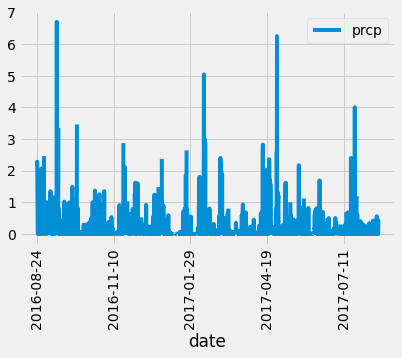

In [35]:
# Use Pandas Plotting with Matplotlib to plot the data
#df = pd.DataFrame(results)
#df.set_index("date", inplace=True)
df.plot(rot=90, x="date", y="prcp")
#plt.show()

In [36]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).count()
print(station_count)

9


In [52]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).all()
print(active_stations)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [53]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_last_year = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date >= year_ago).all()
tobs_last_year_df = pd.DataFrame(tobs_last_year)
tobs_last_year_df.set_index('station', inplace=True)
tobs_last_year_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(close=None, block=None)>

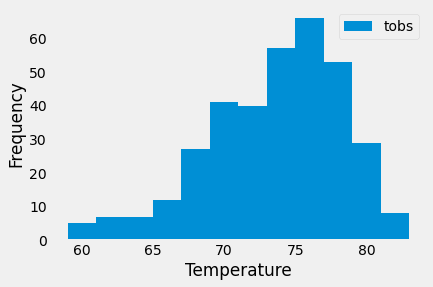

In [54]:
# Histogram plot
tobs_last_year_df.plot.hist(by='station', bins=12)
plt.grid()
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("station_temps_histogram.png")
plt.show

# Close session

In [55]:
# Close Session
session.close()